# Modelo causal y generación de datos

$$
\begin{align}
Z &\leftarrow X \rightarrow Y \\
Z &\rightarrow Y
\end{align}
$$

## DAG

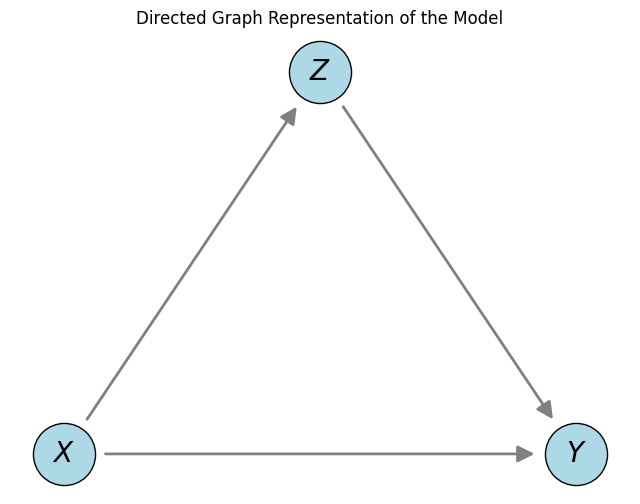

In [ ]:
import networkx as nx

import matplotlib.pyplot as plt

# Crear un nuevo grafo
G = nx.DiGraph()

# Añadir nodos
G.add_node('X')
G.add_node('Y')
G.add_node('Z')

# Añadir aristas (edges) con pesos
G.add_edge('X', 'Y')
G.add_edge('X', 'Z')
G.add_edge('Z', 'Y')

# Añadir etiquetas a los nodos
labels = {
    'X': r'$X$',
    'Y': r'$Y$',
    'Z': r'$Z$'
}

# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(8, 6))
# Dibujar el grafo
pos = {
    "X": (0, 0),
    "Z": (1, 1),
    "Y": (2, 0)
}

# positions for all nodes
nx.draw_networkx_nodes(G, pos,
    node_color='lightblue',
    node_size=2000,
    edgecolors='black'
)

nx.draw_networkx_edges(G, pos,
    arrows=True,
    arrowstyle='-|>',
    arrowsize=25,
    width=2,
    edge_color='gray',
    min_source_margin=30,     
    min_target_margin=30
    )

nx.draw_networkx_labels(G, pos, labels, font_size=20)

# Mostrar el grafo
plt.title('Directed Graph Representation of the Model')
plt.axis('off')  # Turn off the axis
plt.show()

## Ecuaciones estructurales

$$
\begin{align}
Y &= \beta_0 + \beta_1 X + \beta_2 Z + \epsilon_Y \\
Z &= \alpha_0 + \alpha_1 X  + \epsilon_Z
\end{align}
$$

Luego:

$$
\begin{align}
Y &= \beta_0 + \beta_1 X + \beta_2 (\alpha_0 + \alpha_1 X + \epsilon_Z) + \epsilon_Y \\
&= \beta_0 + \beta_2 \alpha_0 + (\beta_1 + \beta_2 \alpha_1) X + (\beta_2 \epsilon_Z + \epsilon_Y)
\end{align}
$$


+ El efecto **total de $X$ sobre $Y$** es $\beta_1 + \beta_2 \alpha_1$.
+ El efecto **directo de $X$ sobre $Y$** es $\beta_1$ y el efecto indirecto es $\beta_2 \alpha_1$.
+ El efecto **indirecto de $X$ sobre $Y$** es el efecto de $X$ sobre $Y$ a través de $Z$ (el total menos el directo).
+ El efecto **total de $Z$ sobre $Y$** coincide con su efecto **directo** y es $\beta_2$. 
+ $Z$ no tiene efecto **indirecto** sobre $Y$.

## Generación de datos


In [21]:
beta_0 = 5
beta_1 = 12
beta_2 = 8
sigma_y = 1

alpha_0 = -3
alpha_1 = 7
sigma_z = 1

N = 10000
# Generate random data
import numpy as np
np.random.seed(42)
X = np.random.normal(0, 1, N)
Z = alpha_0 + alpha_1 * X + np.random.normal(0, sigma_z, N)
Y = beta_0 + beta_1 * X + + beta_2 * Z + np.random.normal(0, sigma_y, N)

# Create a DataFrame
import pandas as pd
data = pd.DataFrame({'X': X, 'Y': Y, 'Z': Z})

data.head()

,X,Y,Z
0,0.496714,9.696891,-0.201496
1,-0.138264,-30.562645,-4.273350
2,0.647689,19.327252,0.936439
3,1.523030,86.028959,7.771627
4,-0.234153,-26.835084,-3.441895


Con los valorea que se generan los datos:

In [19]:
efecto_total_X_Y = beta_1 + beta_2*alpha_1
efecto_directo_X_Y = beta_1
efecto_indirecto_X_Y = beta_2*alpha_1
efecto_total_Z_Y = efecto_directo_Z_Y = beta_2
efecto_indirefcto_Z_Y = 0

print(f"Efecto total de X sobre Y: {efecto_total_X_Y:.2f}")
print(f"Efecto directo de X sobre Y: {efecto_directo_X_Y:.2f}")
print(f"Efecto indirecto de X sobre Y: {efecto_indirecto_X_Y:.2f}")
print(f"Efecto total de Z sobre Y: {efecto_total_Z_Y:.2f}")
print(f"Efecto directo de Z sobre Y: {efecto_directo_Z_Y:.2f}")
print(f"Efecto indirecto de Z sobre Y: {efecto_indirefcto_Z_Y:.2f}")

Efecto total de X sobre Y: 68.00
Efecto directo de X sobre Y: 12.00
Efecto indirecto de X sobre Y: 56.00
Efecto total de Z sobre Y: 8.00
Efecto directo de Z sobre Y: 8.00
Efecto indirecto de Z sobre Y: 0.00


In [9]:
data.corr()

,X,Y,Z
X,1.000000,0.918176,0.870060
Y,0.918176,1.000000,0.796853
Z,0.870060,0.796853,1.000000


# Estimaciones

## Efecto total de $X$ sobre $Y$

A la vista del gráfico y por backdoor criterion, no tenemos que condicionar por / ajustar / controlar por $Z$ porque cerrariamos el camino $X \rightarrow Z \rightarrow Y$ y perderíamos el efecto indirecto de $X$ sobre $Y$ a través de $Z$. Por lo tanto, la estimación del efecto total de $X$ sobre $Y$ es:

$$
Y \sim X
$$

In [22]:
# Fit the model
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Fit the model Y ~ X 
model_y = ols('Y ~ X', data=data).fit()
print(model_y.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                 7.094e+05
Date:                Wed, 19 Mar 2025   Prob (F-statistic):               0.00
Time:                        12:37:54   Log-Likelihood:                -35102.
No. Observations:               10000   AIC:                         7.021e+04
Df Residuals:                    9998   BIC:                         7.022e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -18.9043      0.081   -233.505      0.0

El coeficiente de $X$ coincide con el valor que esperábamos para el efecto total de $X$ sobre $Y$.

## Efecto directo de $X$ sobre $Y$

A la vista del gráfico y por backdoor criterion, tenemos que condicionar por / ajustar / controlar por $Z$ porque cerrariamos el camino $X \rightarrow Z \rightarrow Y$ y así eliminamos el efecto indirecto de $X$ sobre $Y$ a través de $Z$. Por lo tanto, la estimación del efecto directo de $X$ sobre $Y$ es:

$$
Y \sim X + Z
$$

In [23]:
# Fit the model Y ~ X + Z
model_yz = ols('Y ~ X + Z', data=data).fit()
print(model_yz.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.401e+07
Date:                Wed, 19 Mar 2025   Prob (F-statistic):               0.00
Time:                        12:39:09   Log-Likelihood:                -14095.
No. Observations:               10000   AIC:                         2.820e+04
Df Residuals:                    9997   BIC:                         2.822e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.0676      0.031    162.532      0.0

El coeficiente de $X$ coincide con el valor que esperábamos para el efecto directo de $X$ sobre $Y$.

## Efectos total y directo de $Z$ sobre $Y$

A la vista del gráfico y por backdoor criterion, tenemos que condicionar por / ajustar / controlar por $X$ para cerrar el camino $Z \leftarrow X \rightarrow Y$ y así eliminar la relación espuria entre $Z$ e $Y$ a través de $X$. Por lo tanto, la estimación del efecto total y directo de $Z$ sobre $Y$ es:

$$
Y \sim Z + X
$$

es decir, el mismo modelo que el anterior.

Y vemos que, en ese modelo, el coeficiente de $Z$ coincide con el valor que esperábamos para el efecto total y directo de $Z$ sobre $Y$.

# Conclusión: ***backdoor criterion*** y amigos

Para cerrar todos los caminos no causales entre una variable de tratamiento y la variable de resultado, tenemos que:
+ Identificar todos los caminos entrantes en $Y$ y que conectan (tanto causal como espuriamente) con $X$.
+ Cerrar cada uno de ellos condicionando / ajustando / controlando las variables necesarias para **cerrar las *chains* y los *forks*** que encontremos. 
+ Y hacerlo con cuidado de **no abrir en el proceso ningún *collider***. 

No siempre es posible. A veces se pueden aplicar otros algoritmos:

+ ***Frontdoor criterion***
+ ***Instrumental variables***

O la generalización de ellos (***do-Calculus***).

Estos algoritmos son independientes del mecanismo de generación de los datos. Por lo tanto, no importa si los datos son lineales o no. Lo que importa es la estructura causal de los datos.

# Para pensar

En este ejemplo:

+ Hemos podido usar regresiones lineales para estimar los efectos. Pero, **¿qué pasa si los datos no son lineales?** 
+ Además conocíamos todas las variables implicadas y su relación causal. Pero, **¿qué pasa si no las conocemos todas o ignoramos las relaciones entre ellas?**
+ Como los hemos "inventado nosotros" conociamos tanto la estructura causal como el mecanismo de generación de los datos. Pero en condiciones reales no conocemos ni la una ni el otro. Por eso es necesario contar con:
    + **Conocimiento experto**.
    + Datos procedentes de **experimentos**.
    + Algoritmos de ***causal discovery*** (descubrimiento causal).

# Bonus - ¿Qué podrían ser $X$, $Y$ y $Z$?

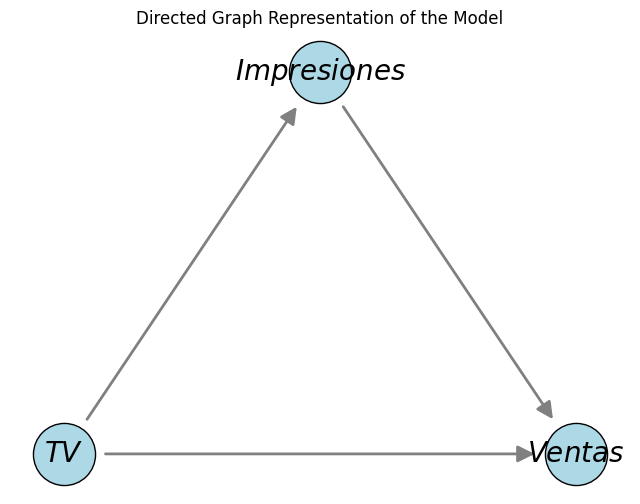

In [30]:
import networkx as nx

import matplotlib.pyplot as plt

# Crear un nuevo grafo
G = nx.DiGraph()

# Añadir nodos
G.add_node('TV')
G.add_node('Ventas')
G.add_node('Impresiones')

# Añadir aristas (edges) con pesos
G.add_edge('TV', 'Ventas')
G.add_edge('TV', 'Impresiones')
G.add_edge('Impresiones', 'Ventas')

# Añadir etiquetas a los nodos
labels = {
    'TV': r'$TV$',
    'Ventas': r'$Ventas$',
    'Impresiones': r'$Impresiones$'
}

# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(8, 6))
# Dibujar el grafo
pos = {
    "TV": (0, 0),
    "Impresiones": (1, 1),
    "Ventas": (2, 0)
}

# positions for all nodes
nx.draw_networkx_nodes(G, pos,
    node_color='lightblue',
    node_size=2000,
    edgecolors='black'
)

nx.draw_networkx_edges(G, pos,
    arrows=True,
    arrowstyle='-|>',
    arrowsize=25,
    width=2,
    edge_color='gray',
    min_source_margin=30,     
    min_target_margin=30
    )

nx.draw_networkx_labels(G, pos, labels, font_size=20)

# Mostrar el grafo
plt.title('Directed Graph Representation of the Model')
plt.axis('off')  # Turn off the axis
plt.show()